In [1]:
import os

import tempfile
import time
import warnings

import cv2
import numpy as np
import tqdm
from matplotlib import pyplot as plt

import detectron2.data.transforms as T
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

from mask2former import add_maskformer2_config
from mask2former.maskformer_sgmllm import MaskFormerForLLM


model_folder="/home/ec2-user/project/Mask2Former-GS/weights/coco_panoptic_swinl_100ep"
cfg = MaskFormerForLLM.get_cfg(model_folder, ckpt_name="model_final.pkl", use_plus=False)
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
)
model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)
model = model.cuda().eval()

/opt/conda/envs/san/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/san/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...
The checkpoint state_dict contains keys that are not used by the model:
  criterion.empty_weight


/data/coco/images/val2017/000000136715.jpg


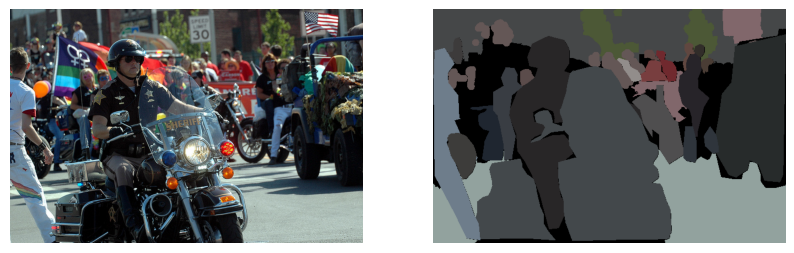

In [16]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from detectron2.data.detection_utils import read_image
# img_fn = "/home/ec2-user/project/SG-MLLM/notebooks/sample/sample3.jpg"
# img = Image.open(img_fn)
img_dir = "/data/coco/images/val2017/"
# img_fn = os.path.join(img_dir, np.random.choice(os.listdir(img_dir)))
img_fn = "/data/coco/images/val2017/000000136715.jpg"
print(img_fn)
img_id = int(img_fn.split("/")[-1].split(".")[0].split("_")[-1])
ann_fn = os.path.join(f"/data/coco/annotations/panoptic_val2017/{img_id:012d}.png")
img = read_image(img_fn, format="RGB")
image = aug.get_transform(img).apply_image(img)
ann = read_image(ann_fn, format="RGB")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(ann)
ax[1].axis('off')
plt.show()

pixel_mean = torch.Tensor(model.pixel_mean).view(-1, 1, 1).cpu()
pixel_std = torch.Tensor(model.pixel_std).view(-1, 1, 1).cpu()
# pixel_mean = model.pixel_mean
# pixel_std = model.pixel_std

image_pt = torch.as_tensor(img.astype("float32").transpose(2, 0, 1))
image_pt = (image_pt - pixel_mean) / pixel_std
image_pt = image_pt.cuda()

with torch.no_grad():
    _, pred = model(image_pt.unsqueeze(0))
    pred = pred[0]


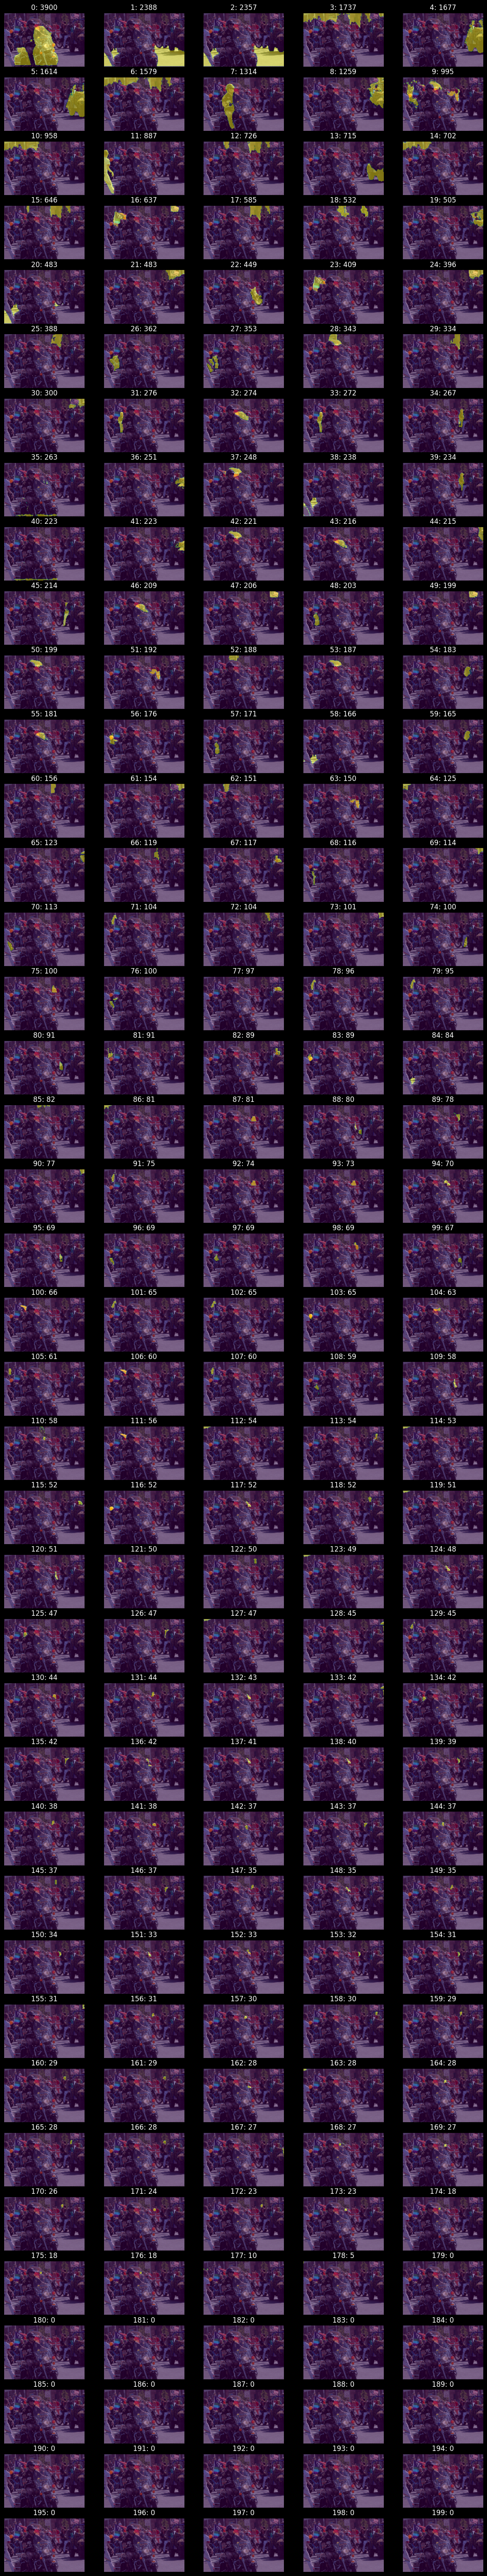

In [17]:

masks = pred.cpu() > 0
areas = masks.sum(dim=(1, 2))
mask_shape = masks.shape[-2:]
h, w = mask_shape

fig, axes = plt.subplots(40, 5, figsize=(15, 120*h/w), facecolor = 'black')
axes = axes.flatten()

img_resized = cv2.resize(img, mask_shape[::-1])
sorted_index = torch.argsort(areas, descending=True)

for i in range(200):
    sidx = sorted_index[i]
    axes[i].axis("off")
    axes[i].imshow(img_resized)
    axes[i].imshow(masks[sidx].numpy(), alpha=0.5)
    axes[i].set_title(f"{i}: {areas[sidx].item():.0f}", color="white")

In [14]:
logits_sum = pred.sum(dim=(1, 2))
sorted_index = torch.argsort(logits_sum)

In [15]:
logits_sum[sorted_index[20]]

tensor(-1064983., device='cuda:0')